In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import contextlib
import einops
import wandb
import pandas as pd
import dotenv
from collections import defaultdict
dotenv.load_dotenv()

from huggingface_hub import login

HF_ACCESS_TOKEN = os.getenv("HF_ACCESS_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
if HF_ACCESS_TOKEN:
    login(token=HF_ACCESS_TOKEN)
    print("Successfully authenticated with Hugging Face.")
else:
    print("Hugging Face access token not found in environment variables.")

if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    print("Successfully authenticated with Weights & Biases.")
else:
    print("Weights & Biases API key not found in environment variables.")


/root/sae-editing
Successfully authenticated with Hugging Face.
Successfully authenticated with Weights & Biases.


In [2]:
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"
pretrained_path = None

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

dtype = torch.bfloat16
if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
# model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from tasks.wmdp.WMDP_MCTask import WMDP_MCTask
from tasks.wmdp.WMDP_RelearnTask import WMDP_RelearnTask
from tasks.wmdp.WMDP_UnlearnTask import WMDP_UnlearnTask, WMDP_UnlearnMCTask
from tasks.general_capabilities.MCTask_redo import run_general_evals
batch_size = 8
# bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, criterion="cross_entropy", injection_task=False)
# bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, injection_task=False)

# injection_bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, criterion="cross_entropy", injection_task=True)
# injection_bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, injection_task=True)
# print(bio_mc_task.test_dataset)
# # acc = 0
# num_iters = len(bio_mc_task.test_dataset) // batch_size


# loss = bio_task.get_test_loss(model, n_iters=num_iters)
# print(f"Biology loss: {loss}")
# acc = bio_mc_task.get_test_accuracy(model, n_iters=num_iters, continuous=False)
# print(f"Biology accuracy: {acc}")
# loss = injection_bio_task.get_test_loss(model, n_iters=num_iters)
# print(f"Biology loss (injection): {loss}")
# acc = injection_bio_mc_task.get_test_accuracy(model, n_iters=num_iters, continuous=False)
# print(f"Biology accuracy (injection): {acc}")

# mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
# print(f"MMLU accuracy: {mmlu['MMLU']}")


print("Biology loss: 2.4375")
print("Biology accuracy: 69.8%")
print("Biology loss (injection): 3.34375")
print("Biology accuracy (injection): 2.9%")
print("MMLU accuracy: 73%")



Biology loss: 2.4375
Biology accuracy: 69.8%
Biology loss (injection): 3.34375
Biology accuracy (injection): 2.9%
MMLU accuracy: 73%


In [4]:
# from tasks.wmdp.WMDP_MCTask import WMDP_DedupedTask
# relearn_bio_mc_task = WMDP_DedupedTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio-retrain", shuffle=True)
# print(relearn_bio_mc_task.get_test_accuracy(model, use_test_data=False, num_iters=10, continuous=False))
# print(relearn_bio_mc_task.get_test_accuracy(model, num_iters=10, continuous=False))

## Initialize SAEs

In [5]:
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=500)
print(pile_task.get_batch())

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [6]:
from sae_lens import SAE

sae_type = "16k"
# sae_layer = 21

sae_dict = {}

sae_layers = range(21)
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    if sae_type == "131k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    elif sae_type == "16k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    
    # for param in sae.parameters():
    #     param.data = param.data.to(torch.bfloat16)

    sae_dict[layer] = sae


  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states

  # target_act = None
  # def gather_target_act_hook(mod, inputs, outputs):
  #   nonlocal target_act # make sure we can modify the target_act from the outer scope
  #   target_act = outputs[0]
  #   return outputs
  # handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  # _ = model.forward(**inputs)
  # handle.remove()
  # return target_act

In [8]:
def get_sae_acts(model, sae, task, n_batches=10, ctx_len=500, text_key="text", return_tokens=True):
    all_sae_acts = []
    for batch_idx in tqdm(range(n_batches)):
        batch = task.get_batch()[text_key]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=ctx_len)
        inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
            with torch.amp.autocast(device_type="cuda"):
                sae_acts = sae.encode(target_act)
        all_sae_acts.append(sae_acts.cpu())
    return torch.cat(all_sae_acts, dim=0)

load_sparsity_dfs = True

if load_sparsity_dfs:
    sparsity_dfs = {}
    for sae_layer in sae_layers:
        sparsity_dfs[sae_layer] = pd.read_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
else:
    sparsity_dfs = {}
    for sae_layer in sae_layers:

        sae = sae_dict[sae_layer]
        if next(sae.parameters()).device.type != "cuda":
            sae = sae.cuda()


        pile_sae_acts = get_sae_acts(model, sae, pile_task, n_batches=50, ctx_len=500, text_key="text")
        print(pile_sae_acts.shape)
        pile_sparsities = (pile_sae_acts > 0).float().mean(dim=0)

        bio_sae_acts = get_sae_acts(model, sae, bio_ce_task, n_batches=50, ctx_len=500, text_key="abstract")
        print(bio_sae_acts.shape)
        bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0)

        sae = sae.cpu()
        sparsity_df = pd.DataFrame({"pile_sparsity": pile_sparsities, "bio_sparsity": bio_sparsities})
        sparsity_df.to_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
        sparsity_dfs[sae_layer] = sparsity_df

# Gradient Update Unlearning

In [9]:
# set up dataset
batch_size = 2

ctx_len = 100
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True, ctx_length=ctx_len)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=ctx_len)
print(pile_task.get_batch())

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [10]:
from collections import defaultdict, deque

class ActivationDataset:
    def __init__(self, task_dict, original_model, activation_layers, number_buffer_batches=128, tokenizer=left_tokenizer, text_cols=None, max_length=500, store_in_cpu=True, keep_model_cpu=False, refresh_dict=None):
        """
        activation_layers: 0-indexed list of layers to store activations from

        keep_model_cpu: if True, keep the model in CPU memory (so send to cuda on refresh and send back)
        refresh_dict: if not None, a dictionary of task name to boolean which is True or False, if True the task's activations will be refreshed
        """
        self.original_model = original_model
        self.activation_layers = activation_layers
        self.number_buffer_batches = number_buffer_batches
        self.buffer = defaultdict(deque)
        self.task_dict = task_dict
        self.tokenizer = tokenizer
        if text_cols is None:
            text_cols = "text"
        if isinstance(text_cols, str):
            self.text_cols = {task_name: text_cols for task_name in task_dict.keys()}
        else:
            self.text_cols = text_cols
        self.max_length = max_length
        self.store_in_cpu = store_in_cpu
        self.keep_model_cpu = keep_model_cpu
        self.refresh_dict = refresh_dict

    def __iter__(self):
        return self
        
    def __next__(self):
        # If any buffer is empty, refresh all buffers
        if any(len(self.buffer[task_name]) == 0 for task_name in self.task_dict.keys()):
            self.refresh()
            
        # Pop one batch from each task's buffer
        try:
            batch = {
                task_name: self.buffer[task_name].popleft() 
                for task_name in self.task_dict.keys()
            }
            return batch
        except IndexError:
            raise StopIteration("Buffer is empty, probably a bug since this should have been refreshed?")

    def refresh(self):
        print("Refreshing buffer")
        self.original_model.cuda()

        # Clear existing buffers
        for task_name in self.task_dict.keys():
            if len(self.buffer[task_name]) > 0:
                print(f"Clearing nonempty buffer for {task_name}, current len: {len(self.buffer[task_name])}")
            self.buffer[task_name].clear()

        # for each task, get number_buffer_batches batches, get input_ids and attention_mask
        for task_name, task in self.task_dict.items():
            for i in range(self.number_buffer_batches):
                # print(f"{torch.cuda.memory_allocated() / 1024 ** 3} GB allocated")
                batch_text = task.get_batch()[self.text_cols[task_name]]
                tokenized = self.tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length)
                input_ids = tokenized["input_ids"].cuda()
                attention_mask = tokenized["attention_mask"].cuda()
                if self.refresh_dict is not None and self.refresh_dict[task_name]:
                    with torch.no_grad():
                        original_output = self.original_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
                        if self.store_in_cpu:
                            original_acts = {layer: original_output.hidden_states[layer+1].cpu() for layer in self.activation_layers}
                        else:
                            original_acts = {layer: original_output.hidden_states[layer+1] for layer in self.activation_layers}

                    if self.store_in_cpu:
                        self.buffer[task_name].append({"input_ids": input_ids.cpu(), "attention_mask": attention_mask.cpu(), "activations": original_acts})
                    else:
                        self.buffer[task_name].append({"input_ids": input_ids, "attention_mask": attention_mask, "activations": original_acts})
                else:
                    self.buffer[task_name].append({"input_ids": input_ids, "attention_mask": attention_mask})

        # add number_buffer_batches to the buffer
        if self.keep_model_cpu:
            self.original_model.cpu()
        print("Buffer refreshed")


activation_layers = [7, 21]



## RMU/Circuit Breakers

In [11]:
lora = False

if pretrained_path is not None:
    train_model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    train_model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
train_model.cuda()
model.eval()
model.cpu()
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Turning off grads for {name} in original model")
        param.requires_grad = False

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Turning off grads for model.embed_tokens.weight in original model
Turning off grads for model.layers.0.self_attn.q_proj.weight in original model
Turning off grads for model.layers.0.self_attn.k_proj.weight in original model
Turning off grads for model.layers.0.self_attn.v_proj.weight in original model
Turning off grads for model.layers.0.self_attn.o_proj.weight in original model
Turning off grads for model.layers.0.mlp.gate_proj.weight in original model
Turning off grads for model.layers.0.mlp.up_proj.weight in original model
Turning off grads for model.layers.0.mlp.down_proj.weight in original model
Turning off grads for model.layers.0.input_layernorm.weight in original model
Turning off grads for model.layers.0.post_attention_layernorm.weight in original model
Turning off grads for model.layers.0.pre_feedforward_layernorm.weight in original model
Turning off grads for model.layers.0.post_feedforward_layernorm.weight in original model
Turning off grads for model.layers.1.self_attn.q_p

In [12]:
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
layers_to_transform = list(range(22))
if lora:
    config = LoraConfig(
        r=16,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "down_proj", "up_proj"],
        layers_to_transform=layers_to_transform,
        lora_alpha=16,
        lora_dropout=0.05
    )
    train_model = get_peft_model(train_model, config)

    learning_rate = 1e-4

else:
    for name, param in train_model.named_parameters():
        param.requires_grad = False
    for layer in range(n_layers):
        if layer in layers_to_transform:
            for param in train_model.model.layers[layer].parameters():
                param.requires_grad = True
        else:
            for param in train_model.model.layers[layer].parameters():
                param.requires_grad = False

    learning_rate = 2e-5

# how many trainable parameters?
trainable_params = 0
for name, param in train_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        trainable_params += param.numel()
print(f"Number of trainable parameters: {trainable_params / 1e9} billion")


model.layers.0.self_attn.q_proj.weight torch.Size([4096, 3584])
model.layers.0.self_attn.k_proj.weight torch.Size([2048, 3584])
model.layers.0.self_attn.v_proj.weight torch.Size([2048, 3584])
model.layers.0.self_attn.o_proj.weight torch.Size([3584, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 3584])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 3584])
model.layers.0.mlp.down_proj.weight torch.Size([3584, 14336])
model.layers.0.input_layernorm.weight torch.Size([3584])
model.layers.0.post_attention_layernorm.weight torch.Size([3584])
model.layers.0.pre_feedforward_layernorm.weight torch.Size([3584])
model.layers.0.post_feedforward_layernorm.weight torch.Size([3584])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 3584])
model.layers.1.self_attn.k_proj.weight torch.Size([2048, 3584])
model.layers.1.self_attn.v_proj.weight torch.Size([2048, 3584])
model.layers.1.self_attn.o_proj.weight torch.Size([3584, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size

# Restrict Gradient Updates using SAEs

In [13]:
def get_sae_acts(layer_acts, sae_layers, sae_dict, feature_dict, apply_nonlinearity=True):

    all_feature_acts = {}
    for layer in sae_layers:
        features = feature_dict[layer]
        sae = sae_dict[layer]
        feature_w = sae.W_enc[:, features] # [hidden, n_features]
        feature_b = sae.b_enc[features] # [n_features]
        threshold = sae.threshold[features] # [n_features]
        with torch.amp.autocast(device_type="cuda", dtype=dtype):
            feature_acts = einops.einsum(layer_acts[layer], feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
            if apply_nonlinearity:
                feature_acts = torch.where(feature_acts > threshold, feature_acts, 0)
            all_feature_acts[layer] = feature_acts
    return all_feature_acts



## Restricting Gradients on Updates

In [14]:
import torch.linalg as LA
# gradients form a subspace
# project onto that subspace?

# What is effective rank of activation gradients? Plot Singular Values of Gradients for a sample parameter

def truncated_svd_gram(M, k):
    """
    M: [n, T] matrix (e.g. stacked gradients), assuming n << T
    k: number of singular components to extract

    Returns:
    U_k: top k left singular vectors, shape [n, k]
    S_k: top k singular values, shape [k]
    V_k: top k right singular vectors, shape [T, k]
    """
    # Gram matrix G is [n, n]
    G = M @ M.T  # shape [n, n]

    # Eigen-decomposition of G (symmetric => use eigh)
    # eigenvals: shape [n], eigenvecs: shape [n, n]
    eigenvals, eigenvecs = torch.linalg.eigh(G)

    # Sort in descending order by eigenvalue
    idx = torch.argsort(eigenvals, descending=True)[:k]
    top_eigvals = eigenvals[idx]            # shape [k]
    top_eigvecs = eigenvecs[:, idx]         # shape [n, k]

    # Singular values = sqrt(eigenvalues)
    S_k = torch.sqrt(top_eigvals)           # shape [k]

    # Left singular vectors = eigenvectors of M M^T
    U_k = top_eigvecs                       # shape [n, k]

    # Right singular vectors = (M^T U_k) / S_k
    # M^T is [T, n], U_k is [n, k], so (M^T U_k) is [T, k]
    V_k = M.T @ U_k
    V_k = V_k / S_k.unsqueeze(0)           # broadcast divide

    return U_k, S_k, V_k


def get_masks(model, task, activation_layers, sae_layers, n_features, pile_clamp_thresholds, num_batches, mask_top_quantile=.999, sample_frac=1, task_type="corpus"):
    masks = {}
    # for activation_layer in tqdm(activation_layers):
    # param_grad_list = []
    original_requires_grad = {}

    for name, param in model.named_parameters():
        original_requires_grad[name] = param.requires_grad
        param.requires_grad = False
        # for layer in activation_layers:
        for activation_layer in activation_layers:
            if f"model.layers.{activation_layer}." in name:
                param.requires_grad = True
                break
            # param_grad_list.append(name)
            

    model.zero_grad()

    feature_dict = {}

    for sae_layer in sae_layers:
        sae_dict[sae_layer] = sae_dict[sae_layer].cuda()
        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= pile_clamp_thresholds[sae_layer], 1, 0) * sparsity_df["bio_sparsity"] * sparsity_df["bio_related"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        features = features_sorted.head(n_features).index.tolist()
        feature_dict[sae_layer] = features


    # task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)

    for batch_idx in range(num_batches):
        batch = task.get_batch()
        if task_type == "corpus":
            tokenized_batch = tokenizer(batch["abstract"], return_tensors="pt", padding=True, truncation=True, max_length=100)
            output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
            acts = {layer: output.hidden_states[layer+1] for layer in sae_layers}
        elif task_type == "fact_unlearn":
            tokenized_batch = tokenizer(batch["prompt"], return_tensors="pt", padding=True, truncation=True, max_length=100)
            output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
            acts = {}
            for layer in sae_layers:
                # num_subject_tokens = 0
                total_hidden_states = output.hidden_states[layer+1]
                answer_hidden_states = []
                for i in range(len(total_hidden_states)):
                    answer_hidden_states.append(total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1])
                    # print(total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1].shape)
                    # num_subject_tokens += len(answer_hidden_states[-1])
                acts[layer] = torch.cat(answer_hidden_states, dim=0)
                # print(f"{num_subject_tokens=}")
                # print(f"{acts[layer].shape=}")
            # acts = {layer: output.hidden_states[layer+1] for layer in sae_layers}
            
        sae_acts = get_sae_acts(acts, sae_layers, sae_dict, feature_dict)
        total_loss = 0
        for sae_layer in sae_layers:
            total_loss += sae_acts[sae_layer].sum()
        total_loss.backward()

    # Concatenate all gradients into a single tensor
    all_grads = []
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grad = param.grad.abs().flatten()
            if sample_frac < 1:
                # grad = grad[torch.randperm(len(grad))[:int(len(grad) * sample_frac)]]
                grad = grad[:int(len(grad) * sample_frac)]
            all_grads.append(grad.float())
    all_grads = torch.cat(all_grads)

    # Calculate single threshold across all gradients
    n = all_grads.numel()
    # k = int(n * (1 - mask_top_quantile))  # This gives k for the larger threshold
    k = int(n * mask_top_quantile)
    
    # plt.hist(all_grads.cpu().float().numpy(), bins=100)
    # plt.yscale("log")
    # plt.show()
    threshold = torch.kthvalue(all_grads, k).values.item()
    # print(f"threshold: {threshold}, {all_grads.median()=}, {all_grads.shape=}")

    all_grads.cpu()
    del all_grads
    # print(f"{all_grads.shape}, n: {n}, k: {k}, threshold: {threshold}")
    # Create masks using the single threshold
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            masks[name] = (param.grad.abs() > threshold)
            # print(f"Masking {name} with threshold {threshold}")
            # print(param.grad.abs())
            # print(f"median: {param.grad.abs().median()}, threshold: {threshold}, number elements masked: {masks[name].sum().item()}")

    model.zero_grad()
    # finally, restore the original requires_grad values
    for name, param in model.named_parameters():
        param.requires_grad = original_requires_grad[name]
    return masks

In [15]:
def low_rank_projection(param, A_matrix):
    # A_matrix is the matrix of the first k columns of the V matrix from SVD: the low rank projection
    # shape (flattened_param_size, k), 
    original_param_shape = param.shape
    flattened_param = param.flatten()
    low_rank_param = einops.einsum(flattened_param, A_matrix, "flattened_param_size, flattened_param_size k -> k")
    reprojected_param = einops.einsum(low_rank_param, A_matrix, "k, flattened_param_size k -> flattened_param_size")
    reshaped_param = reprojected_param.reshape(original_param_shape)
    return reshaped_param

def apply_gradient_projections(model, v_projections):
    for name, param in model.named_parameters():
        if param.requires_grad:
            assert name in v_projections, f"Gradient projection for {name} not found"
            param.grad = low_rank_projection(param.grad, v_projections[name])

def apply_gradient_masks(model, masks):
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            if name in masks:
                # print(f"Applying mask to gradient {name}")
                param.grad = param.grad * masks[name]
            else:
                print(f"Gradient mask for {name} not found")


In [16]:
# log 1 minus p on forget corpus
batch_size = 2
ctx_len = 100
from tasks.wmdp.WMDP_MCTask import WMDP_DedupedTask, WMDP_MCTask
from tasks.wmdp.WMDP_UnlearnTask import WMDP_UnlearnTask, WMDP_UnlearnMCTask

activation_layers = list(range(22))
# activation_layers = [7, 21]

# k = 2
sae_layers = [7, 21]
n_features = 10
pile_clamp_thresholds = {7: 0.05, 14: .05, 21: 0.03, 35: 0.01}
num_batches = 200
mask_top_quantile = .99
sample_frac = 0.05

# mask_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
mask_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False)
task_type = "fact_unlearn"
model.cpu()
# v_projections = get_v_projections(model, task, activation_layers, sae_layers, n_features, pile_clamp_thresholds, num_batches, k)
# v_projections['model.layers.7.self_attn.q_proj.weight'].shape

tasks = {"bio": WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, criterion="log_1_minus_p", injection_task=False),
         "bio_injection": WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, criterion="cross_entropy", injection_task=True),
         "pile": PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=ctx_len)
         }
eval_batch_size = 8
bio_mc_task = WMDP_UnlearnMCTask(batch_size=eval_batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, injection_task=False)
bio_injection_mc_task = WMDP_UnlearnMCTask(batch_size=eval_batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True, split="first_two", train_test_split=False, injection_task=True)
num_eval_iters = len(bio_mc_task.test_dataset) // eval_batch_size * 2
print(f"Number of evaluation iterations for MC: {num_eval_iters}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Parameter 'function'=<bound method WMDP_UnlearnMCTask.format_row of <tasks.wmdp.WMDP_UnlearnTask.WMDP_UnlearnMCTask object at 0x7f95f05795b0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Number of evaluation iterations for MC: 34


### Visualize masks per layer

In [17]:
masks = get_masks(train_model, mask_task, activation_layers, sae_layers, n_features, pile_clamp_thresholds, num_batches, mask_top_quantile=mask_top_quantile, sample_frac=0.05, task_type=task_type)

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


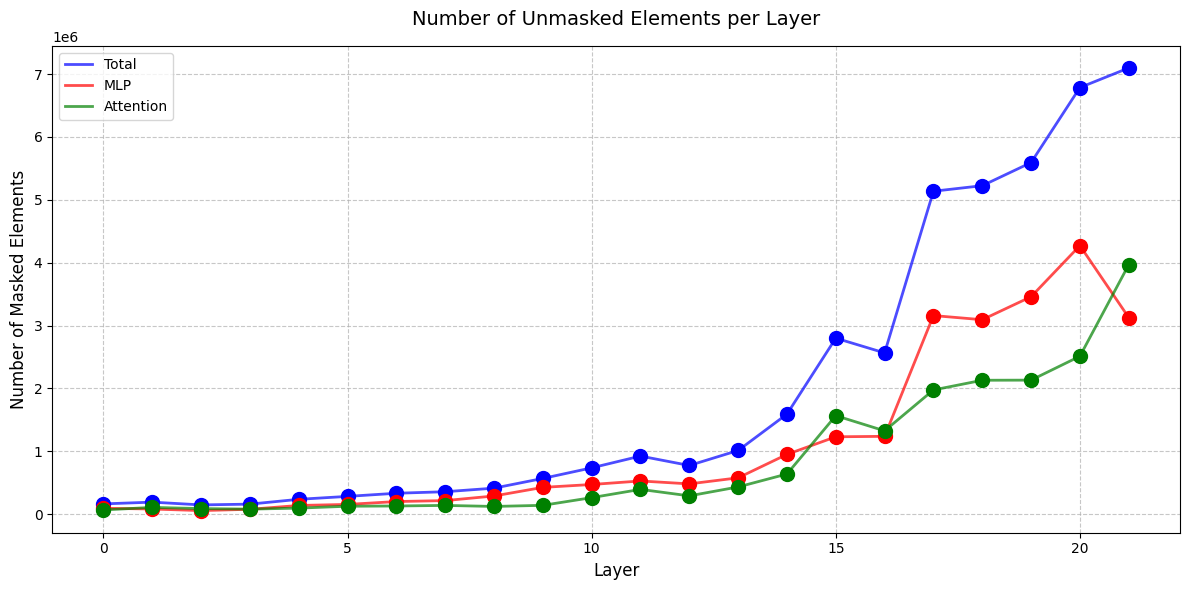

In [18]:
layer_mask_elements = defaultdict(int)
mlp_layer_mask_elements = defaultdict(int)
attn_layer_mask_elements = defaultdict(int)
for name, mask in masks.items():
    # get layer
    layer = int(name.split(".")[2])
    layer_mask_elements[layer] += mask.sum().item()
    if "mlp" in name:
        mlp_layer_mask_elements[layer] += mask.sum().item()
    elif "attn" in name:
        attn_layer_mask_elements[layer] += mask.sum().item()

import matplotlib.pyplot as plt

# Convert defaultdicts to regular dicts and sort by layer
layers = sorted(layer_mask_elements.keys())
total_counts = [layer_mask_elements[layer] for layer in layers]
mlp_counts = [mlp_layer_mask_elements[layer] for layer in layers]
attn_counts = [attn_layer_mask_elements[layer] for layer in layers]

plt.figure(figsize=(12, 6))

# Plot total counts
plt.plot(layers, total_counts, 'b-', linewidth=2, alpha=0.7, label='Total')
plt.scatter(layers, total_counts, color='blue', s=100, zorder=5)

# Plot MLP counts
plt.plot(layers, mlp_counts, 'r-', linewidth=2, alpha=0.7, label='MLP')
plt.scatter(layers, mlp_counts, color='red', s=100, zorder=5)

# Plot attention counts
plt.plot(layers, attn_counts, 'g-', linewidth=2, alpha=0.7, label='Attention')
plt.scatter(layers, attn_counts, color='green', s=100, zorder=5)

# Styling
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Number of Unmasked Elements per Layer', fontsize=14, pad=15)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Number of Masked Elements', fontsize=12)
plt.legend(fontsize=10)

# Add some padding to the axes
plt.margins(x=0.05)

plt.tight_layout()
plt.show()

### Train model, refreshing masks

In [19]:
n_steps = 500

# grad_accum_steps = 4
evaluate_every = 10
refresh_masks_every = 100

grad_accum_steps = 16 // batch_size
learning_rate = 1e-5

if lora:
    optimizer = torch.optim.AdamW(train_model.parameters(), lr=learning_rate, weight_decay=0)
else:
    import bitsandbytes as bnb
    optimizer = bnb.optim.AdamW8bit(train_model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_steps)

circuit_breaker_coef = 1

do_gradient_masking = False
apply_mask_to_retain = True

# Initialize wandb run before training
wandb.init(
    project="sae-unlearning",
    config={
        "unlearning_method": "masked_gradient_descent_mc_data" if do_gradient_masking else "gradient_descent_mc_data",
        "learning_rate": learning_rate,
        "n_steps": n_steps,
        "lora": lora,
        "activation_layers": activation_layers,
        "model": model_name_or_path,
        "circuit_breaker_coef": circuit_breaker_coef,
        "refresh_masks_every": refresh_masks_every,
        "apply_mask_to_retain": apply_mask_to_retain,
        "sae_layers": sae_layers,
        "n_sae_features": n_features,
        "mask_top_quantile": mask_top_quantile,
        "sample_frac": sample_frac,
        "task_type": task_type
    }
)

for step in tqdm(range(n_steps)):
    if step % refresh_masks_every == 0 and do_gradient_masking:
        print("Refreshing masks")
        masks = get_masks(train_model, mask_task, activation_layers, sae_layers, n_features, pile_clamp_thresholds, num_batches, mask_top_quantile=mask_top_quantile, sample_frac=sample_frac, task_type=task_type)
        print("Done refreshing masks")
    # Track per-layer losses for logging
    total_rerouting_loss = 0
    total_injection_rerouting_loss = 0
    # total_cyber_retain_loss = 0
    total_retain_loss = 0
    
    # Calculate coefficients
    progress = step / n_steps
    progress = progress ** 2
    retain_coef = 1


    # first do rerouting, mask
    for accum_step in range(grad_accum_steps):
        current_rerouting_loss = tasks["bio"].get_train_loss(train_model)
        
        # Scale loss and backward
        (circuit_breaker_coef * current_rerouting_loss / grad_accum_steps).backward()
        total_rerouting_loss += current_rerouting_loss.item() / grad_accum_steps

        current_injection_rerouting_loss = tasks["bio_injection"].get_train_loss(train_model)
        (circuit_breaker_coef * current_injection_rerouting_loss / grad_accum_steps).backward()
        total_injection_rerouting_loss += current_injection_rerouting_loss.item() / grad_accum_steps
    if not apply_mask_to_retain and do_gradient_masking:
        apply_gradient_masks(train_model, masks)

    # then do unmasked retain
    # Gradient accumulation loop
    for accum_step in range(grad_accum_steps):

        # Retain (cyber) forward pass
        # current_cyber_retain_loss = tasks["cyber"].get_train_loss(train_model)
        
        # # Scale loss and backward
        # (retain_coef * current_cyber_retain_loss / grad_accum_steps).backward()
        # total_cyber_retain_loss += current_cyber_retain_loss.item() / grad_accum_steps

        # Retain (pile) forward pass
        current_retain_loss = tasks["pile"].get_train_loss(train_model)
        
        # Scale loss and backward
        (retain_coef * current_retain_loss / grad_accum_steps).backward()
        total_retain_loss += current_retain_loss.item() / grad_accum_steps

    if apply_mask_to_retain and do_gradient_masking:
        apply_gradient_masks(train_model, masks)
    # Update weights after accumulation
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    eval_metrics = {}
    if (step+1) % evaluate_every == 0:
        print("Evaluating")
        # bio_loss = tasks["bio"].get_test_loss(train_model, n_iters=grad_accum_steps)
        # print(f"Bio loss: {bio_loss:.3f}")
        bio_mc_acc = bio_mc_task.get_test_accuracy(train_model, n_iters=num_eval_iters)
        print(f"Bio MC accuracy: {bio_mc_acc:.3f}")
        injection_bio_mc_acc = bio_injection_mc_task.get_test_accuracy(train_model, n_iters=num_eval_iters)
        print(f"Injection Bio MC accuracy: {injection_bio_mc_acc:.3f}")
        mmlu = run_general_evals(train_model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=2, device="cuda")["MMLU"]
        print(f"MMLU: {mmlu:.3f}")
        # eval_metrics["bio_loss"] = bio_loss
        eval_metrics["bio_mc_acc"] = bio_mc_acc
        eval_metrics["injection_bio_mc_acc"] = injection_bio_mc_acc
        eval_metrics["mmlu"] = mmlu

    # total_loss = circuit_breaker_coef * total_rerouting_loss + retain_coef * (total_cyber_retain_loss + total_retain_loss)
    total_loss = circuit_breaker_coef * total_rerouting_loss + circuit_breaker_coef * total_injection_rerouting_loss + retain_coef * total_retain_loss

    # Evaluation and logging code...
    wandb.log({
        "loss/total": total_loss,
        "loss/rerouting": total_rerouting_loss,
        "loss/injection_rerouting": total_injection_rerouting_loss,
        "loss/retain": total_retain_loss,
        # "loss/cyber_retain": total_cyber_retain_loss,
        "progress": progress,
        "learning_rate": scheduler.get_last_lr()[0],
        **eval_metrics
    }, step=step)

# Close wandb run when done
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating
Bio MC accuracy: 0.433
Injection Bio MC accuracy: 0.250


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.630
Evaluating
Bio MC accuracy: 0.384
Injection Bio MC accuracy: 0.300


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.580
Evaluating
Bio MC accuracy: 0.385
Injection Bio MC accuracy: 0.300


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.650
Evaluating
Bio MC accuracy: 0.350
Injection Bio MC accuracy: 0.282


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.620
Evaluating
Bio MC accuracy: 0.328
Injection Bio MC accuracy: 0.360


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.650
Evaluating
Bio MC accuracy: 0.300
Injection Bio MC accuracy: 0.358


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.640
Evaluating
Bio MC accuracy: 0.297
Injection Bio MC accuracy: 0.346


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.650
Evaluating
Bio MC accuracy: 0.294
Injection Bio MC accuracy: 0.328


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.640
Evaluating
Bio MC accuracy: 0.297
Injection Bio MC accuracy: 0.305


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.600
Evaluating
Bio MC accuracy: 0.315
Injection Bio MC accuracy: 0.317


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.600
Evaluating
Bio MC accuracy: 0.292
Injection Bio MC accuracy: 0.331


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.610
Evaluating
Bio MC accuracy: 0.293
Injection Bio MC accuracy: 0.286


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.610
Evaluating
Bio MC accuracy: 0.298
Injection Bio MC accuracy: 0.337


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.610
Evaluating
Bio MC accuracy: 0.320
Injection Bio MC accuracy: 0.324


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.590
Evaluating
Bio MC accuracy: 0.303
Injection Bio MC accuracy: 0.311


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.600
Evaluating
Bio MC accuracy: 0.293
Injection Bio MC accuracy: 0.304


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.610
Evaluating
Bio MC accuracy: 0.330
Injection Bio MC accuracy: 0.301


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.610
Evaluating
Bio MC accuracy: 0.316
Injection Bio MC accuracy: 0.306


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.620
Evaluating
Bio MC accuracy: 0.330
Injection Bio MC accuracy: 0.303


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.620
Evaluating
Bio MC accuracy: 0.309
Injection Bio MC accuracy: 0.278


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.620
Evaluating
Bio MC accuracy: 0.315
Injection Bio MC accuracy: 0.314


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.630
Evaluating
Bio MC accuracy: 0.327


KeyboardInterrupt: 

In [20]:
# save peft on hf
run_id = 5
name = model_type + ("-sae-masked-gd-mc" if do_gradient_masking else "-gd-mc") + f"-{run_id}" + ("-lora" if lora else "-fullrank")
print(f"Saving to {name}")
train_model.save_pretrained(name)
train_model.push_to_hub(
    name, 
    # use_auth_token=True,
    commit_message="220 steps, wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/w0jdzn8j?nw=nwuserphilliphguo"
)

Saving to gemma-2-gd-mc-5-fullrank


model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PhillipGuo/gemma-2-gd-mc-5-fullrank/commit/3c4d99f3dcdbdd830cd37fd227f790ece6aeb536', commit_message='220 steps, wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/w0jdzn8j?nw=nwuserphilliphguo', commit_description='', oid='3c4d99f3dcdbdd830cd37fd227f790ece6aeb536', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PhillipGuo/gemma-2-gd-mc-5-fullrank', endpoint='https://huggingface.co', repo_type='model', repo_id='PhillipGuo/gemma-2-gd-mc-5-fullrank'), pr_revision=None, pr_num=None)